In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import anndata
import scvelo as scv

from scipy.sparse import csr_matrix
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.neighbors import kneighbors_graph
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from RnaVeloDataset import RnaVeloDataset
from symsimDataset import SymsimDataset
from unsupervised_loss import UnsupervisedLoss

import torch
import torch.nn.functional as F
import torch.nn as nn
from sklearn.metrics import roc_auc_score
from torch_geometric.data import DataLoader
from RnaVeloDataset import RnaVeloDataset
from model.BaseModel import BaseModel
from sklearn.metrics import mean_squared_error
from model.mymodel import MyModel, GraphSAGEModel, FCModel, veloModel
from math import sqrt
import scprep

from torch_geometric.data import Data

In [22]:
def train(train_loader, lamb):
    model.train()

    total_loss = 0
    mse = nn.MSELoss()
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        """
        Note that here I change the output of the model to incorporate the adj matrix (after the sigmoid transform)
        """
        output = model(data)
        # output, node_embed, adj = model(data)
        # adj = adj.numpy()
        # print(node_embed.shape)

        # eliminate self node
        # adj = adj - adj[0,0] * np.diag(np.ones(adj.shape[0]))
        # print(np.where(adj[0,:] != 0)[0])

        # train_nodes = np.arange(adj.shape[0])
        #  print(train_nodes[0])

        # unsupervised_loss = unsup_loss.UnsupervisedLoss(adj = adj, train_nodes=train_nodes, device = device)
        # nodes_batch = np.asarray(list(unsupervised_loss.extend_nodes(nodes=train_nodes, num_neg=6)))
        # loss_net = unsupervised_loss.get_loss_sage(node_embed, nodes_batch)

        label = data.y.to(device)
        loss = torch.sqrt(mse(output, label)) # + lamb * loss_net
        loss.backward()
        total_loss += data.num_graphs * loss.item()
        optimizer.step()

    return float(total_loss / len(train_loader.dataset))

def test(loader):
    model.eval()
    
    correct = []
    predict = []
    for data in loader:
        data = data.to(device)
        label = data.y.detach().cpu().numpy().reshape(-1)
        # pred,_,_ = model(data)
        pred = model(data)
        pred = pred.detach().cpu().numpy().reshape(-1)
        correct.extend(label)
        predict.extend(pred)
    correct = np.array(correct)
    predict = np.array(predict)
    return sqrt(mean_squared_error(correct, predict))


In [18]:
import importlib
import symsimDataset as symsim
importlib.reload(symsim)
dataset = symsim.SymsimDataset(root="data/")

In [19]:
len(dataset)

150

In [20]:
dataset.num_features

300

## Train bifurcate and tree

In [33]:
# dataset = RnaVeloDataset(root='data/')

t = np.arange(1,10)
# dataset for training
train_mask = list(t) + list(t+10) + list(t+20) + list(t+30) + list(t+40) + list(t+50) + list(t+60) + list(t+70) + list(t+80) + list(t+90) + list(t+100) + list(t +110) + list(t+120) + list(t+130) + list(t+140)
#　train_mask = [3, 4, 5, 6]
# dataset for validation
val_mask = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140]

In [34]:
import importlib
import unsupervised_loss as unsup_loss
importlib.reload(unsup_loss)

<module 'unsupervised_loss' from 'c:\\Users\\jenso\\Study\\GT\\traj_inference\\vel_r\\unsupervised_loss.py'>

In [35]:
# mask the dataset
train_loader = DataLoader(dataset[train_mask], batch_size=1, shuffle=True)
val_loader = DataLoader(dataset[val_mask], batch_size=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model = GraphSAGEModel(dataset.num_features, device).to(device)
# model = FCModel(dataset.num_features, device).to(device)
model = FCModel(dataset.num_features, device).to(device)
# reset parameters
model.reset_parameters()
print(model)

optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4, weight_decay=0.01)

train_list = []
val_list = []
for epoch in range(101):

    train_loss = train(train_loader,lamb=1e-4)
    train_acc = test(train_loader)
    val_acc = test(val_loader)
    log = 'Epoch: {:03d}, Loss: {:.4f}, Train: {:.4f}, Val: {:.4f}'
    if epoch % 10 == 0:
        print(log.format(epoch, train_loss, train_acc, val_acc))
    
    train_list.append(train_acc)
    val_list.append(val_acc)

FCModel(
  (lin1): Linear(in_features=300, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=64, bias=True)
  (lin3): Linear(in_features=64, out_features=1, bias=True)
)
Epoch: 000, Loss: 0.2750, Train: 0.2532, Val: 0.2549
Epoch: 010, Loss: 0.0882, Train: 0.0855, Val: 0.1056
Epoch: 020, Loss: 0.0814, Train: 0.0784, Val: 0.1080
Epoch: 030, Loss: 0.0761, Train: 0.0728, Val: 0.1093
Epoch: 040, Loss: 0.0709, Train: 0.0679, Val: 0.1121
Epoch: 050, Loss: 0.0661, Train: 0.0636, Val: 0.1135
Epoch: 060, Loss: 0.0624, Train: 0.0599, Val: 0.1157
Epoch: 070, Loss: 0.0590, Train: 0.0564, Val: 0.1171
Epoch: 080, Loss: 0.0561, Train: 0.0540, Val: 0.1177
Epoch: 090, Loss: 0.0540, Train: 0.0519, Val: 0.1176
Epoch: 100, Loss: 0.0525, Train: 0.0505, Val: 0.1190


In [28]:
Path = "./trained_model/gnnSage_symsim.pt"
torch.save(model.state_dict(), Path)

In [29]:
Path = "./trained_model/gnnSage_symsim.pt"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 1
train_loader = DataLoader(dataset[train_mask], batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset[val_mask], batch_size=1)
# model = GraphSAGEModel(dataset.num_features, device).to(device)
model = veloModel(dataset.num_features, device).to(device)
model.load_state_dict(torch.load(Path))
model.eval()

veloModel(
  (conv1): GraphConvolutionSage (300 -> 32)
  (conv2): GraphConvolutionSage (32 -> 8)
  (lin1): Linear(in_features=16, out_features=1, bias=True)
)

In [11]:
def pca_op(X, n_comps = 2, standardize  = True):
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import Pipeline
    from sklearn.decomposition import PCA
    if standardize:
        pipeline = Pipeline([('standardize', StandardScaler()), ('pca', PCA(n_components=n_comps))])
    else:
        pipeline = Pipeline([('pca', PCA(n_components=n_comps))])
    X_pca = pipeline.fit_transform(X)
    return X_pca

In [12]:
def umap_op(X, n_comps = 2):
    from umap import UMAP
    Umap = UMAP(n_components=n_comps)
    X_umap = Umap.fit_transform(X)
    return X_umap

In [25]:
def scatter(data, figsize = (15,5), method = 'pca'):
    # X should be something before pca
    if isinstance(data.x, torch.Tensor):
        X = data.x.numpy()
    elif isinstance(data.x, np.ndarray):
        X = data.x
    else:
        raise ValueError('tensor or numpy array')
    
    if isinstance(data.y, torch.Tensor):
        y = data.y.numpy().squeeze()
    elif isinstance(data.y, np.ndarray):
        y = data.y
    else:
        raise ValueError('tensor or numpy array')
    if method == 'pca':
        X_pca = pca_op(X, n_comps = 2, standardize=False)
    elif method == 'umap':
        X_pca = umap_op(X, n_comps = 2)
    else:
        raise ValueError("either pca or umap")
    
    data = data.to(device)
    # pred,_,_ = model(data)
    pred = model(data)
    pred = pred.detach().cpu().numpy().reshape(-1)
    rmse = sqrt(mean_squared_error(y, pred))


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    ax1.set_title("Prediction, RMSE="+str(rmse)[:5])
    ax2.set_title("Simulation Time")
    v1 = ax1.scatter(X_pca[:,0],X_pca[:,1], cmap = 'gnuplot', c=pred)
    fig.colorbar(v1, fraction=0.046, pad=0.04, ax = ax1)
    v2 = ax2.scatter(X_pca[:,0],X_pca[:,1], cmap = 'gnuplot', c=y)
    fig.colorbar(v1, fraction=0.046, pad=0.04, ax = ax2)
    plt.figure(figsize=figsize)
    plt.show()

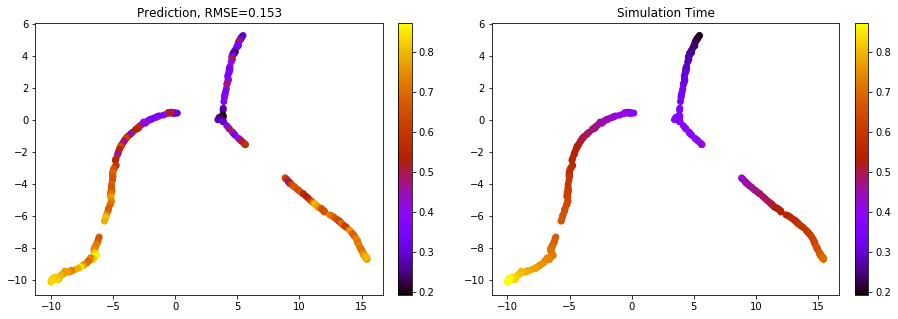

<Figure size 1080x360 with 0 Axes>

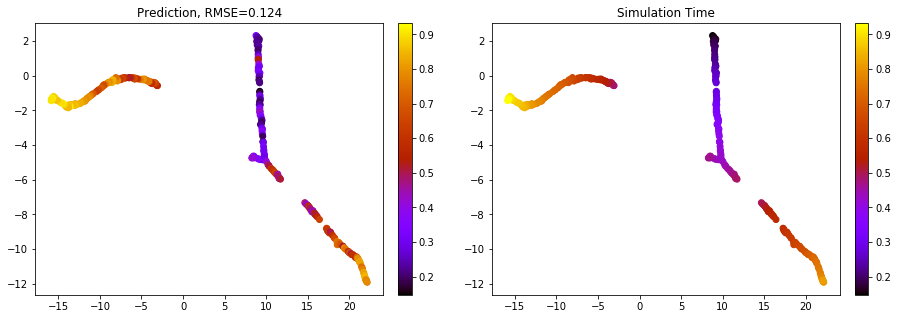

<Figure size 1080x360 with 0 Axes>

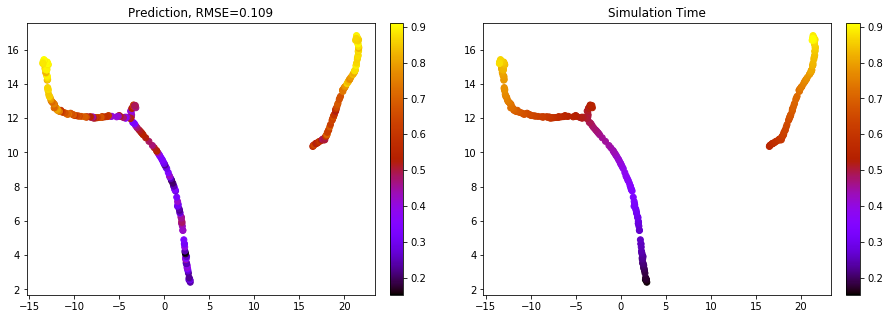

<Figure size 1080x360 with 0 Axes>

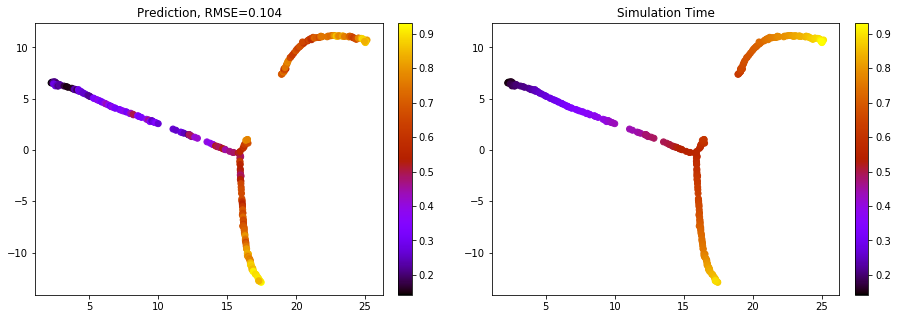

<Figure size 1080x360 with 0 Axes>

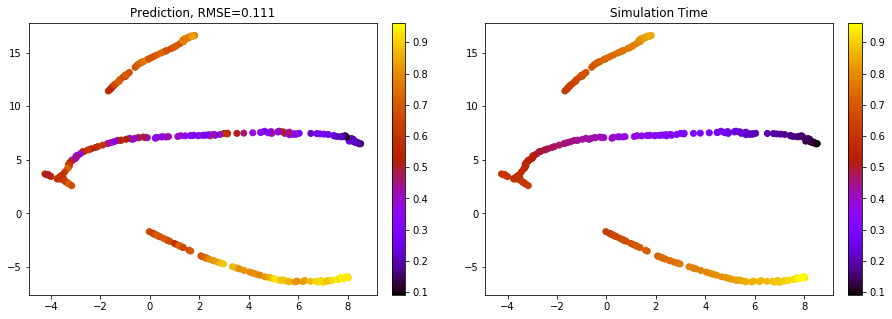

<Figure size 1080x360 with 0 Axes>

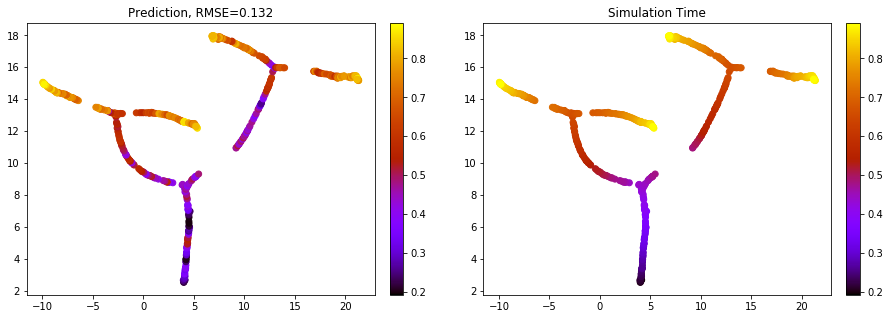

<Figure size 1080x360 with 0 Axes>

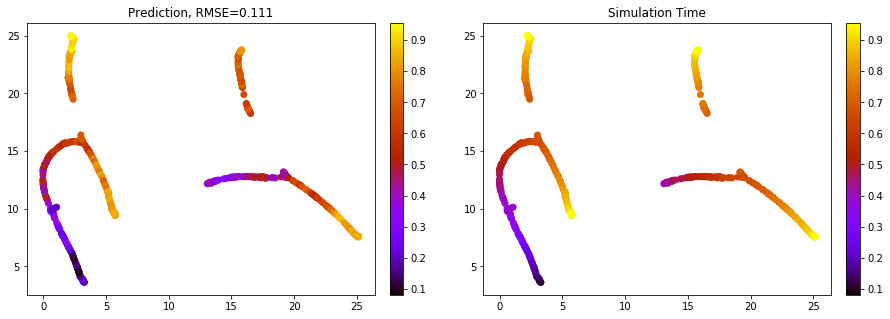

<Figure size 1080x360 with 0 Axes>

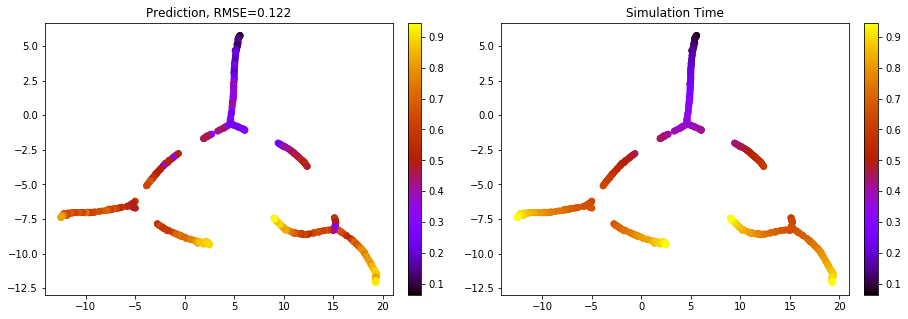

<Figure size 1080x360 with 0 Axes>

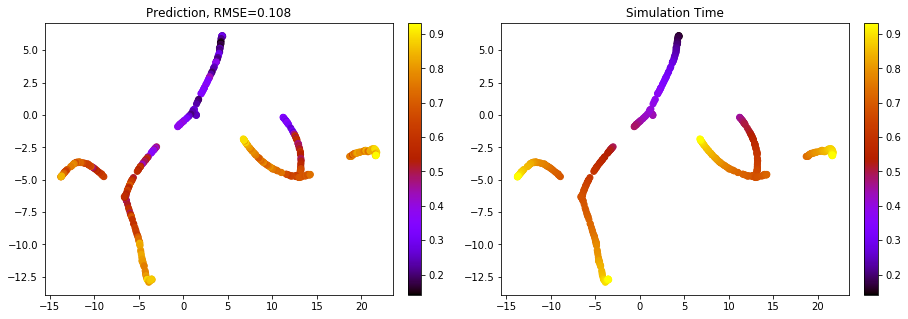

<Figure size 1080x360 with 0 Axes>

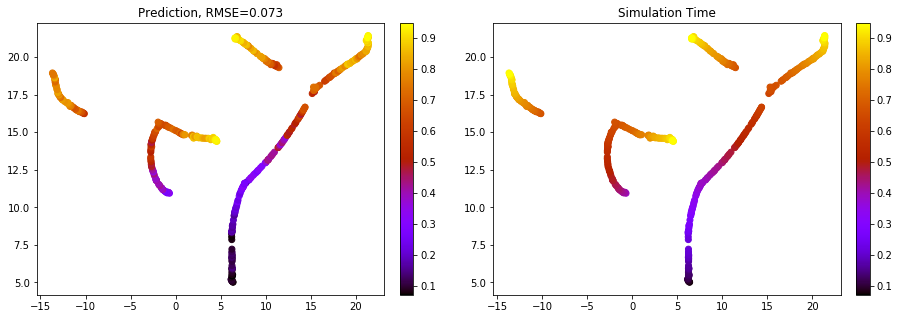

<Figure size 1080x360 with 0 Axes>

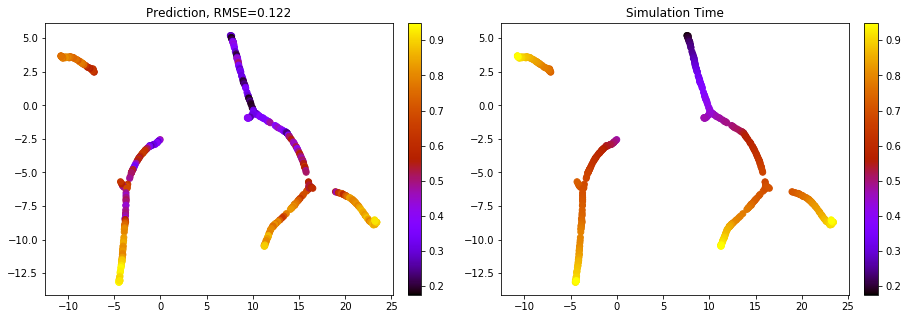

<Figure size 1080x360 with 0 Axes>

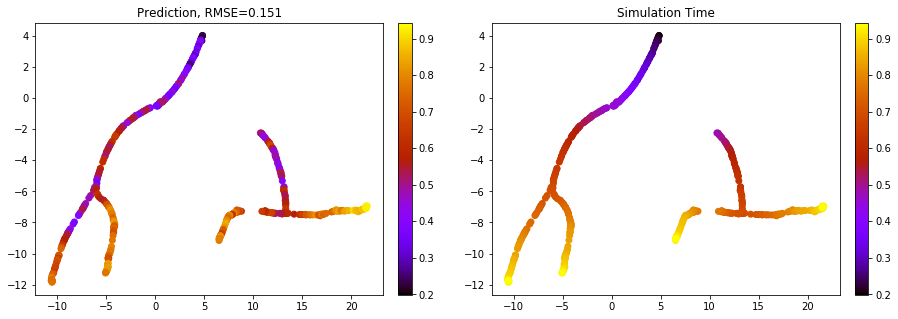

<Figure size 1080x360 with 0 Axes>

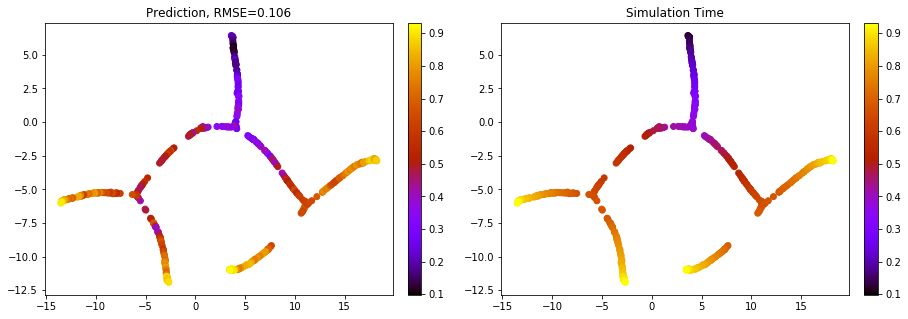

<Figure size 1080x360 with 0 Axes>

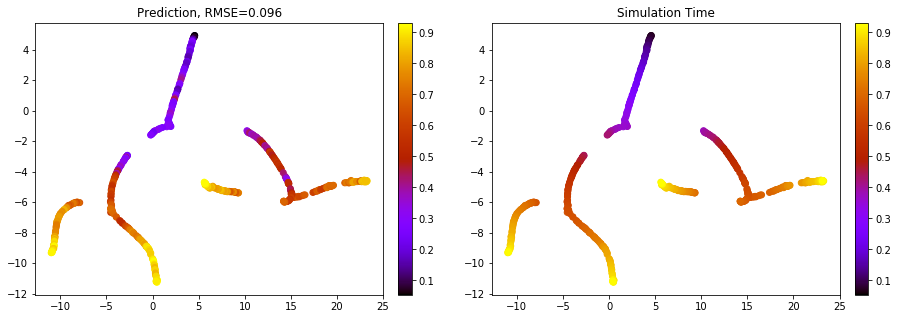

<Figure size 1080x360 with 0 Axes>

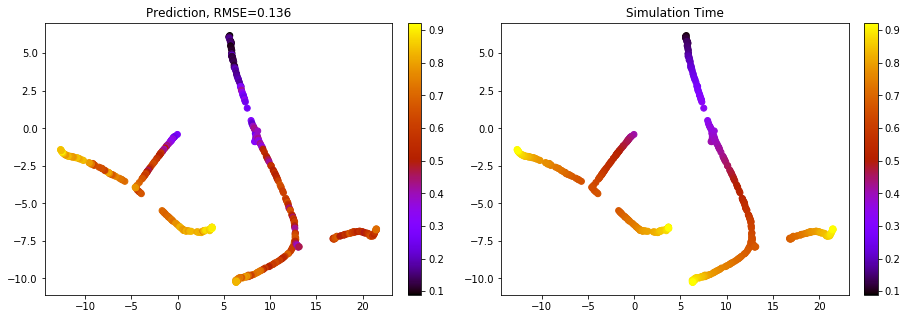

<Figure size 1080x360 with 0 Axes>

In [36]:
for data in val_loader:
    scatter(data, method='umap')

## Train 50 bifurcate test 10 tree

In [37]:
train_mask = list(t) + list(t+10) + list(t+20) + list(t+30) + list(t+40)
val_mask = list(t + 140)

In [38]:
# mask the dataset
train_loader = DataLoader(dataset[train_mask], batch_size=1, shuffle=True)
val_loader = DataLoader(dataset[val_mask], batch_size=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model = GraphSAGEModel(dataset.num_features, device).to(device)
# model = FCModel(dataset.num_features, device).to(device)
model = FCModel(dataset.num_features, device).to(device)
# reset parameters
model.reset_parameters()
print(model)

optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4, weight_decay=0.01)

train_list = []
val_list = []
for epoch in range(101):

    train_loss = train(train_loader,lamb=1e-4)
    train_acc = test(train_loader)
    val_acc = test(val_loader)
    log = 'Epoch: {:03d}, Loss: {:.4f}, Train: {:.4f}, Val: {:.4f}'
    if epoch % 10 == 0:
        print(log.format(epoch, train_loss, train_acc, val_acc))
    
    train_list.append(train_acc)
    val_list.append(val_acc)

FCModel(
  (lin1): Linear(in_features=300, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=64, bias=True)
  (lin3): Linear(in_features=64, out_features=1, bias=True)
)
Epoch: 000, Loss: 0.2699, Train: 0.2632, Val: 0.2932
Epoch: 010, Loss: 0.0858, Train: 0.0841, Val: 0.1420
Epoch: 020, Loss: 0.0701, Train: 0.0690, Val: 0.1418
Epoch: 030, Loss: 0.0623, Train: 0.0613, Val: 0.1444
Epoch: 040, Loss: 0.0563, Train: 0.0553, Val: 0.1479
Epoch: 050, Loss: 0.0511, Train: 0.0498, Val: 0.1496
Epoch: 060, Loss: 0.0461, Train: 0.0445, Val: 0.1513
Epoch: 070, Loss: 0.0410, Train: 0.0396, Val: 0.1540
Epoch: 080, Loss: 0.0366, Train: 0.0354, Val: 0.1533
Epoch: 090, Loss: 0.0334, Train: 0.0328, Val: 0.1543
Epoch: 100, Loss: 0.0310, Train: 0.0304, Val: 0.1536


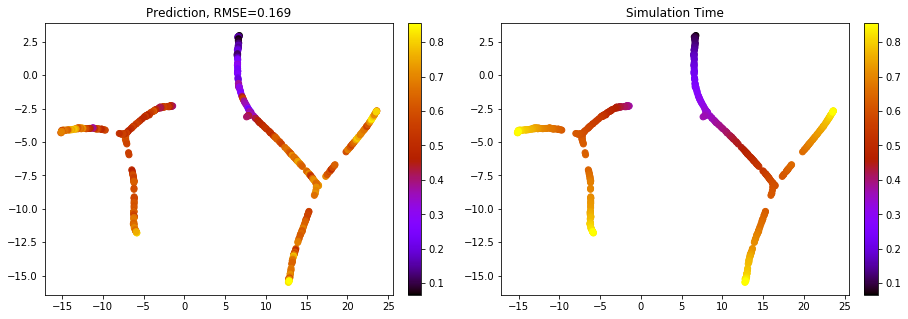

<Figure size 1080x360 with 0 Axes>

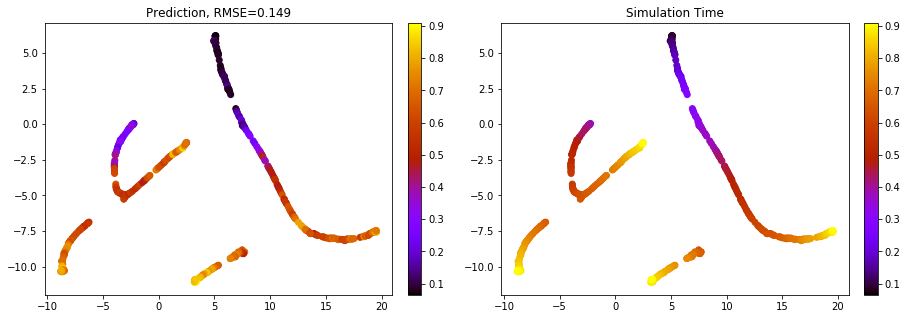

<Figure size 1080x360 with 0 Axes>

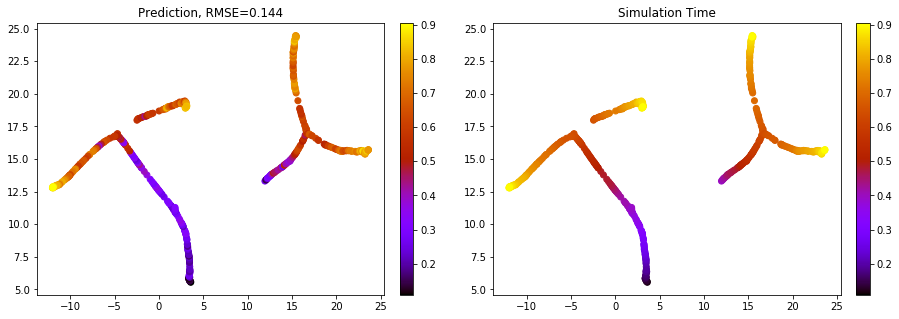

<Figure size 1080x360 with 0 Axes>

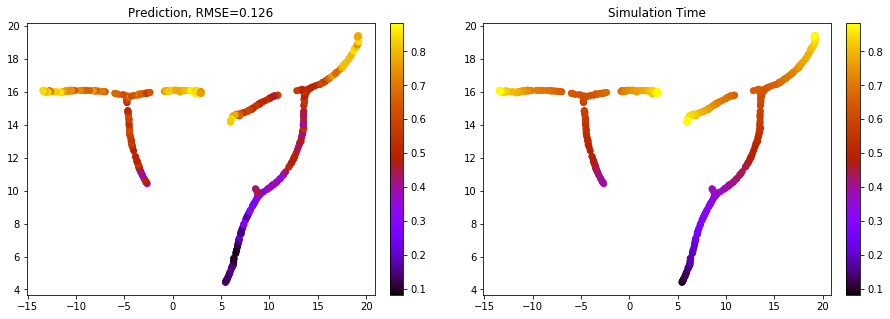

<Figure size 1080x360 with 0 Axes>

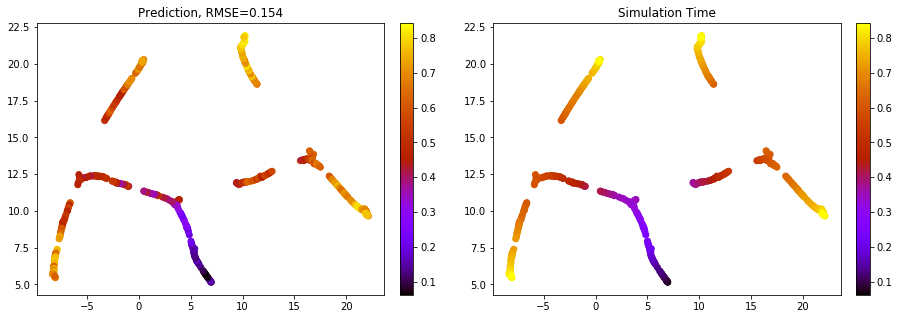

<Figure size 1080x360 with 0 Axes>

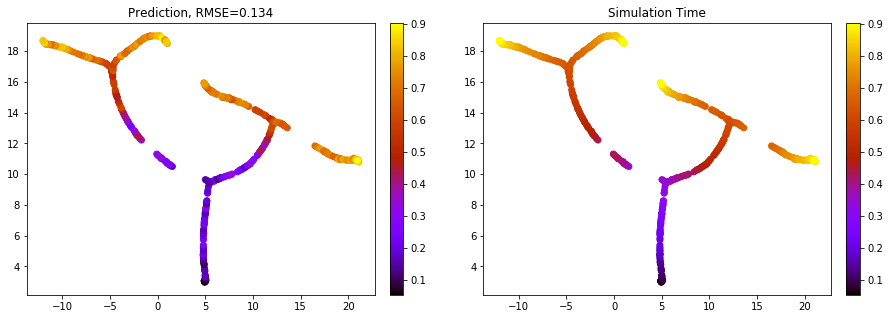

<Figure size 1080x360 with 0 Axes>

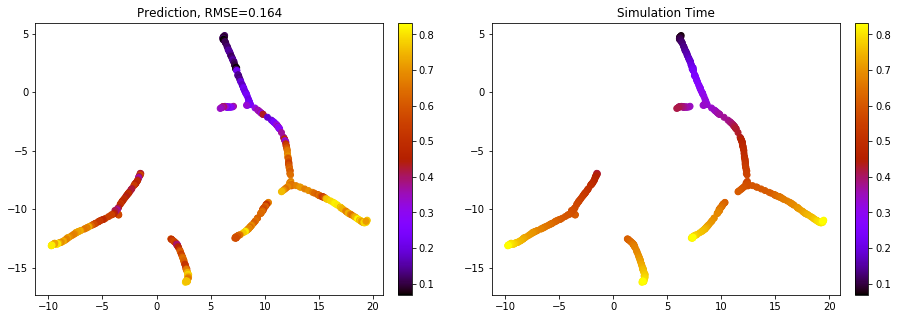

<Figure size 1080x360 with 0 Axes>

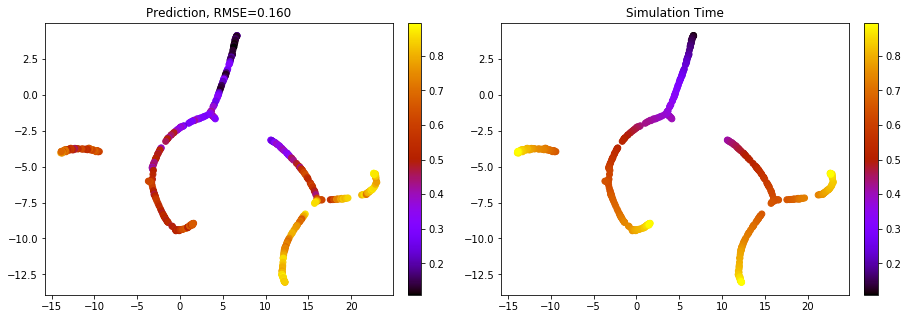

<Figure size 1080x360 with 0 Axes>

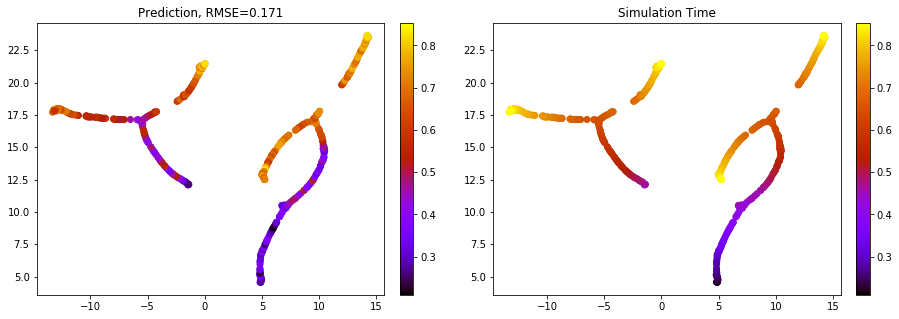

<Figure size 1080x360 with 0 Axes>

In [39]:
for data in val_loader:
    scatter(data, method='umap')

## Train 50 tree test 10 bifurcate

In [40]:
train_mask = list(t+100) + list(t +110) + list(t+120) + list(t+130) + list(t+140)
val_mask = list(t)

In [41]:
# mask the dataset
train_loader = DataLoader(dataset[train_mask], batch_size=1, shuffle=True)
val_loader = DataLoader(dataset[val_mask], batch_size=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model = GraphSAGEModel(dataset.num_features, device).to(device)
# model = FCModel(dataset.num_features, device).to(device)
model = FCModel(dataset.num_features, device).to(device)
# reset parameters
model.reset_parameters()
print(model)

optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4, weight_decay=0.01)

train_list = []
val_list = []
for epoch in range(101):

    train_loss = train(train_loader,lamb=1e-4)
    train_acc = test(train_loader)
    val_acc = test(val_loader)
    log = 'Epoch: {:03d}, Loss: {:.4f}, Train: {:.4f}, Val: {:.4f}'
    if epoch % 10 == 0:
        print(log.format(epoch, train_loss, train_acc, val_acc))
    
    train_list.append(train_acc)
    val_list.append(val_acc)

FCModel(
  (lin1): Linear(in_features=300, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=64, bias=True)
  (lin3): Linear(in_features=64, out_features=1, bias=True)
)
Epoch: 000, Loss: 0.3016, Train: 0.2876, Val: 0.2458
Epoch: 010, Loss: 0.0829, Train: 0.0806, Val: 0.1536
Epoch: 020, Loss: 0.0678, Train: 0.0666, Val: 0.1538
Epoch: 030, Loss: 0.0609, Train: 0.0599, Val: 0.1544
Epoch: 040, Loss: 0.0560, Train: 0.0546, Val: 0.1523
Epoch: 050, Loss: 0.0511, Train: 0.0498, Val: 0.1516
Epoch: 060, Loss: 0.0466, Train: 0.0453, Val: 0.1496
Epoch: 070, Loss: 0.0425, Train: 0.0412, Val: 0.1517
Epoch: 080, Loss: 0.0393, Train: 0.0382, Val: 0.1535
Epoch: 090, Loss: 0.0365, Train: 0.0358, Val: 0.1532
Epoch: 100, Loss: 0.0346, Train: 0.0336, Val: 0.1554


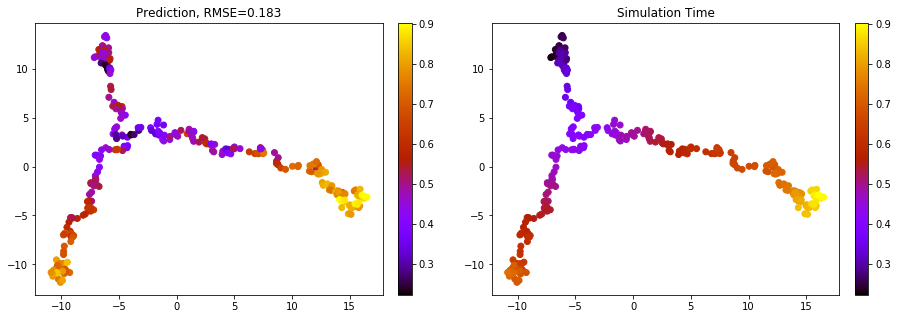

<Figure size 1080x360 with 0 Axes>

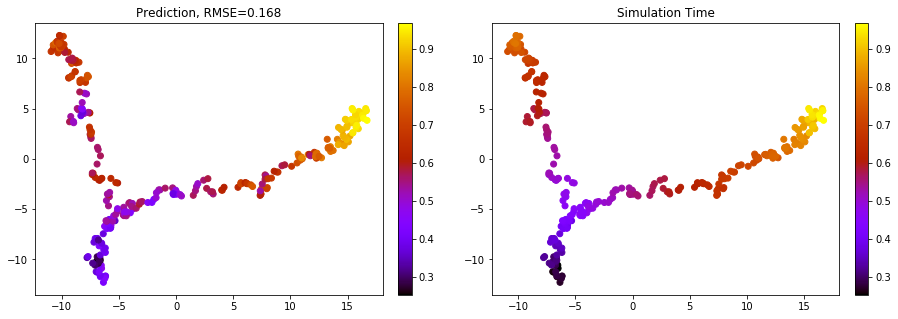

<Figure size 1080x360 with 0 Axes>

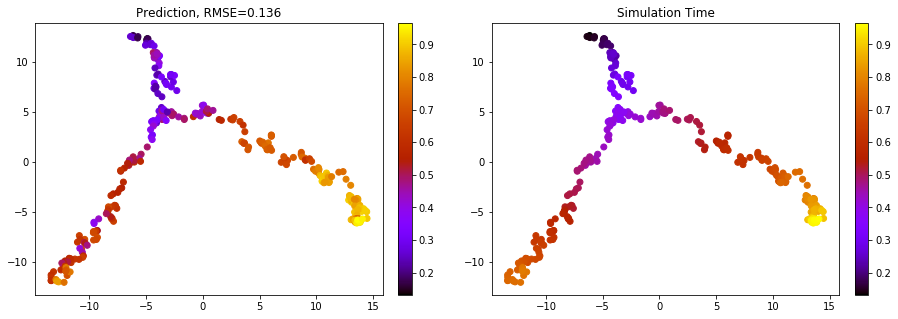

<Figure size 1080x360 with 0 Axes>

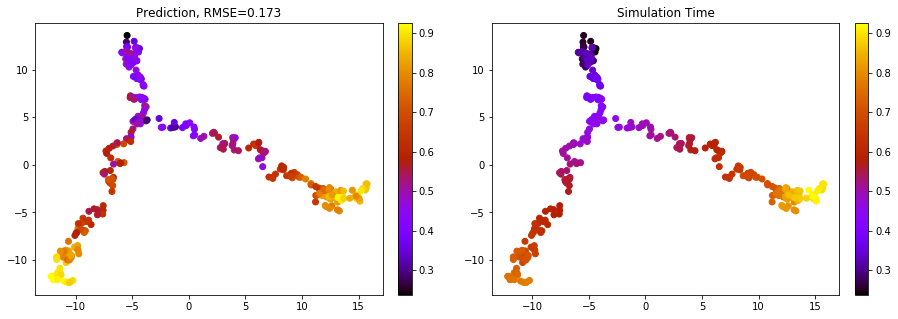

<Figure size 1080x360 with 0 Axes>

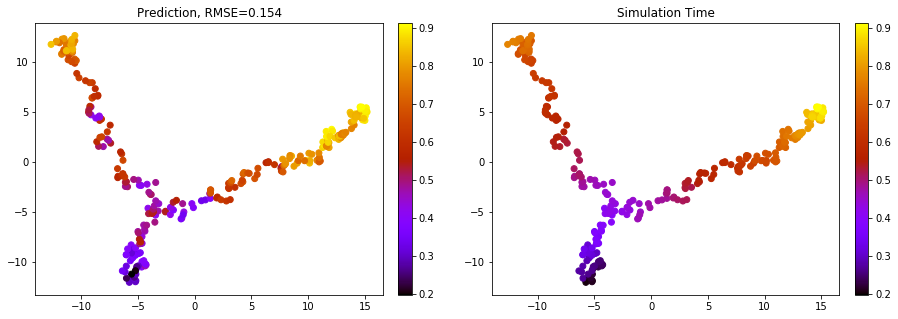

<Figure size 1080x360 with 0 Axes>

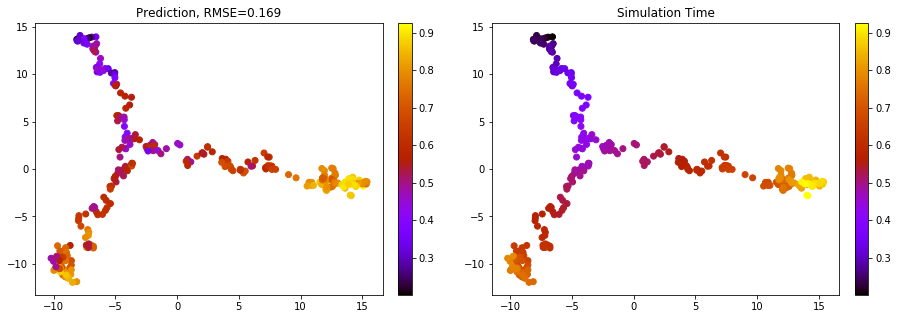

<Figure size 1080x360 with 0 Axes>

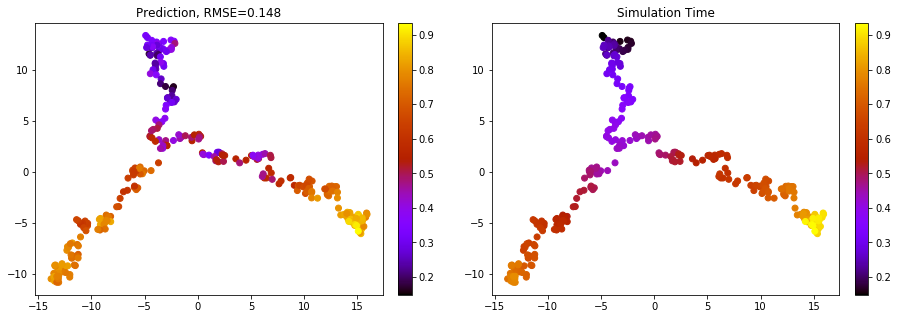

<Figure size 1080x360 with 0 Axes>

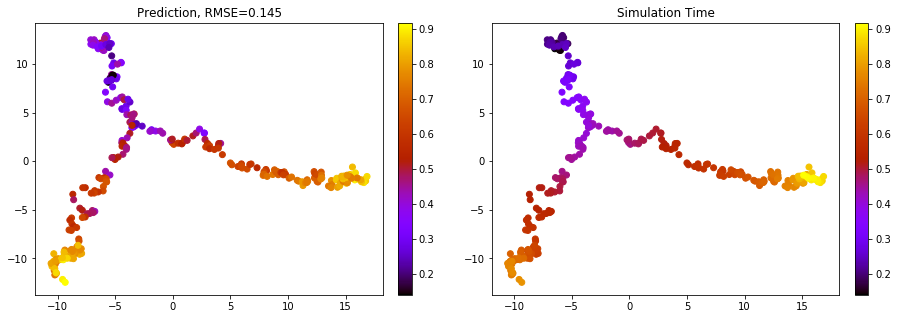

<Figure size 1080x360 with 0 Axes>

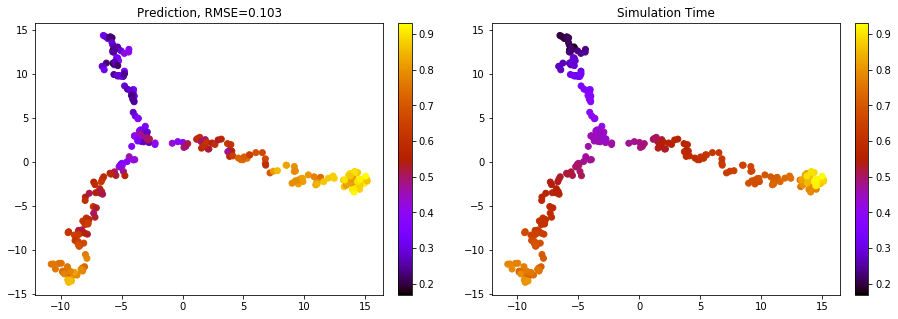

<Figure size 1080x360 with 0 Axes>

In [42]:
for data in val_loader:
    scatter(data)

## Pearson Correlation Loss

In [43]:
def train(train_loader, lamb):
    model.train()

    total_loss = 0
    mse = nn.MSELoss()
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        """
        Note that here I change the output of the model to incorporate the adj matrix (after the sigmoid transform)
        """
        output = model(data)
        label = data.y.to(device)

        vx = output - torch.mean(output)
        vy = label - torch.mean(label)
        loss = torch.sum(vx * vy) / (torch.sqrt(torch.sum(vx ** 2)) * torch.sqrt(torch.sum(vy ** 2)))

        loss.backward()
        total_loss += data.num_graphs * loss.item()
        optimizer.step()

    return float(total_loss / len(train_loader.dataset))

def test(loader):
    model.eval()
    
    correct = []
    predict = []
    for data in loader:
        data = data.to(device)
        label = data.y.detach().cpu().numpy().reshape(-1)
        # pred,_,_ = model(data)
        pred = model(data)
        pred = pred.detach().cpu().numpy().reshape(-1)
        correct.extend(label)
        predict.extend(pred)
    correct = np.array(correct)
    predict = np.array(predict)
    return sqrt(mean_squared_error(correct, predict))

In [44]:
train_mask = list(t) + list(t+10) + list(t+20) + list(t+30) + list(t+40) + list(t+50) + list(t+60) + list(t+70) + list(t+80) + list(t+90) + list(t+100) + list(t +110) + list(t+120) + list(t+130) + list(t+140)

val_mask = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140]

In [45]:
# mask the dataset
train_loader = DataLoader(dataset[train_mask], batch_size=1, shuffle=True)
val_loader = DataLoader(dataset[val_mask], batch_size=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model = GraphSAGEModel(dataset.num_features, device).to(device)
# model = FCModel(dataset.num_features, device).to(device)
model = FCModel(dataset.num_features, device).to(device)
# reset parameters
model.reset_parameters()
print(model)

optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4, weight_decay=0.01)

train_list = []
val_list = []
for epoch in range(101):

    train_loss = train(train_loader,lamb=1e-4)
    train_acc = test(train_loader)
    val_acc = test(val_loader)
    log = 'Epoch: {:03d}, Loss: {:.4f}, Train: {:.4f}, Val: {:.4f}'
    if epoch % 10 == 0:
        print(log.format(epoch, train_loss, train_acc, val_acc))
    
    train_list.append(train_acc)
    val_list.append(val_acc)

FCModel(
  (lin1): Linear(in_features=300, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=64, bias=True)
  (lin3): Linear(in_features=64, out_features=1, bias=True)
)
Epoch: 000, Loss: -0.5511, Train: 0.3004, Val: 0.2967


KeyboardInterrupt: 